In [1]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
import imageio.v3
import glob

In [2]:
# neural network class definition
class neuralNetwork:
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        self.lr = learningrate
        self.activation_function = lambda x: scipy.special.expit(x)

    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        output_errors = targets - final_outputs
        hidden_errors = np.dot(self.who.T, output_errors)
        
        self.who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
        self.wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))

    def query(self, inputs_list):
        inputs = np.array(inputs_list, ndmin=2).T
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs

In [3]:
# number of input, hidden and output nodes
input_nodes = 1024 * 768
hidden_nodes = 2000
output_nodes = 4  # Four quadrants

# learning rate
learning_rate = 0.1

In [4]:
# create instance of neural network
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

# prepare training data for the SLM scenario
def create_quadrant_data(img, quadrant):
    img_array = imageio.v3.imread(img, mode='L')
    img_data = img_array.flatten() 
    img_data = (img_data / 255.0 * 0.99) + 0.01

    targets = np.zeros(output_nodes) + 0.01
    targets[quadrant] = 0.99

    return img_data, targets

In [5]:
# simulate training data
training_data = []
quadrant_dirs = ['quadrant_0', 'quadrant_1', 'quadrant_2', 'quadrant_3']

for quadrant in range(4):
    img_files = glob.glob('training_images/{quadrant_dirs[quadrant]}/*.png')
    for img_file in img_files:
        training_data.append(create_quadrant_data(img_file, quadrant))

# train the neural network
epochs = 2500
for e in range(epochs):
    for inputs, targets in training_data:
        n.train(inputs, targets)


In [6]:
# test the neural network with a new image
print("loading ... test_images/test_image.png")
test_img_array = imageio.v3.imread('resized_images\quadrant_2_image_2_training_resized.png', mode='L')

# ensure the image is 1024x768
if test_img_array.shape != (768, 1024):
    raise ValueError("Input image must be 1024x768 pixels")

# flatten and preprocess the test image
test_img_data = test_img_array.flatten() 
test_img_data = (test_img_data / 255.0 * 0.99) + 0.01

loading ... test_images/test_image.png


[[0.41792306]
 [0.34776028]
 [0.43875044]
 [0.45059618]]
network says quadrant  3


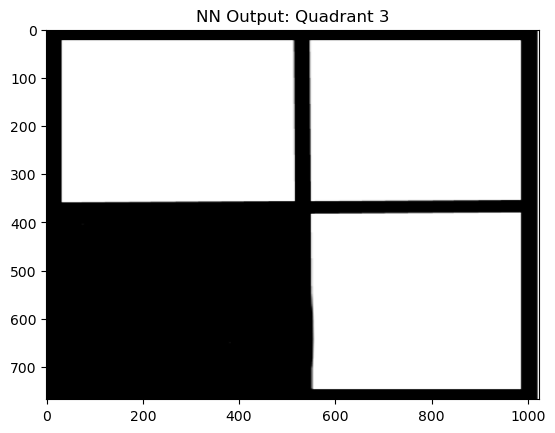

In [7]:

# plot image
plt.imshow(test_img_array, cmap='Greys_r', interpolation='None')

# query the network
outputs = n.query(test_img_data)
print(outputs)

# the index of the highest value corresponds to the dark quadrant
quadrant_label = np.argmax(outputs)
print("network says quadrant ", quadrant_label)
plt.title(f"NN Output: Quadrant {quadrant_label}")
plt.show()